In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf

# I made my own folder with some downloads because as I'll write down below, gr_disp is NOT in utils
# ... or rather, it is, but there's another utils folder and the unpacked one is in another folder
# See how to get it in "Tutotial I" from module 4
from marco import gr_disp
from marco import inception
from PIL import Image

C:\Users\marco\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Create a simple graph
input = tf.placeholder(name = 'input', shape=(), dtype=tf.float32)
out1 = input + 5
out2 = input * out1
gr_disp.show(tf.get_default_graph().as_graph_def())

In [4]:
# First, always reset the graph
tf.reset_default_graph()

# Define name, data type and shape of the input array as a tensor
# At this stage, only an emmpty placeholder is defined
input_arr = tf.placeholder(name='input_arr', dtype=tf.float32, shape=(5,))

# Define the function
squared = tf.multiply(input_arr, input_arr)

# reduce_sum computes the sum of elements across dimensions
out_sum = tf.reduce_sum(squared)

In [5]:
#Convert the input (1,2,3,4,5) into an array
np_arr = np.asarray((1,2,3,4,5), dtype=np.float32)

# A SESSION object encapsulates the environment in which operation objects are executed, and tensor objects are evaluated
# It follows the following route: Build the graph, launch the graph, evaluate the tensor (with Session.run())
# Sessions should be closed when they are no longer needed. If you run it using the "with ... as ...:" argument, it does so automatically
# Also see: https://www.tensorflow.org/api_docs/python/tf/Session
# Important: It is generally discouraged to use feed_dict as it's slow

with tf.Session() as sess:
    print(sess.run(out_sum, feed_dict={input_arr: np_arr}))

55.0


In [6]:
# Reset the graph
tf.reset_default_graph()

# Define name, data type and shape of the input array as a tensor. None stands for unknows length of the array (first axis)
input_arr = tf.placeholder(name='input_arr', dtype=tf.float32, shape=(None, 5))

# Do the same as before, except this time, we sum along the axis
squared = tf.multiply(input_arr, input_arr)
out_sum = tf.reduce_sum(squared, axis=1)

#Sample arrays of different size along first axis. 
#They all can be fed into the input_arr placeholder since size of first axis is unconstrained
np_arr1 = np.asarray([[1,2,3,4,5]], dtype=np.float32)
np_arr2 = np.asarray([[1,2,3,4,5], [2,3,4,5,6]], dtype=np.float32)
np_arr3 = np.asarray([[1,2,3,4,5], [2,3,4,5,6], [25,65,12,12,13], [1,2,3,4,9], [2,13,4,15,6], [25,45,12,12,11], [1,3,5,7,9]], dtype=np.float32)

with tf.Session() as sess:
    print(sess.run(out_sum, feed_dict={input_arr: np_arr1}))
    print(sess.run(out_sum, feed_dict={input_arr: np_arr2}))
    print(sess.run(out_sum, feed_dict={input_arr: np_arr3}))

[55.]
[55. 90.]
[  55.   90. 5307.  111.  450. 3059.  165.]


## Optimization problem

In ML we always try to optimize model parameters to minimize a loss function. TensorFlow allows for easy optimization problem solving.

We will use a function $f$, parabolic with respect to the model parameter $t$: $f(x_1, x_2|t) = (x_1*t-x_2)^2$. Here $x_1$ and $x_2$ are given values for which we will try to minimize the value of function $f$.

We define `t` as a variable using `get_variable` and initialize it with a constant 0. The parameter $t$ is what we aim to optimize in trying to minimize $f$.

In [7]:
# As always, we reset the graph
# @Q: Why do we reset the graph if we don't use it anymore?
tf.reset_default_graph()

# Define t, x1 and x2. This isn't as fluid in TensorFlow as it is in Python
t = tf.get_variable(name='t', dtype=tf.float32, shape=(), initializer=tf.constant_initializer(0))
x1 = tf.placeholder(name='x1', dtype=tf.float32, shape=())
x2 = tf.placeholder(name='x2', dtype=tf.float32, shape=())

# Define the function to be minimized
f = tf.square(t*x1-x2)

# Define the optimizer we will use, the learning rate and the function to be minimized
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(f)

Text(0.5,1,'f(itr)')

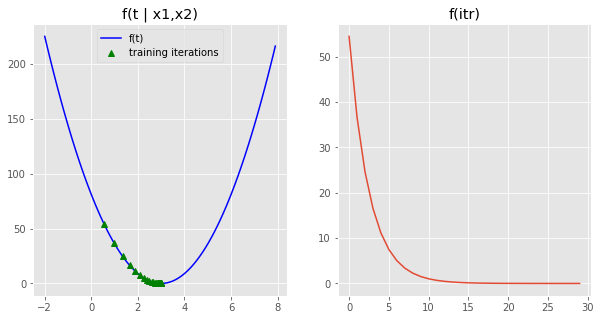

In [8]:
# Values of x1, x2 for which we will minimize f
x1_val = 3.
x2_val = 9.

# Buffers to store intermediate values of t and f to plot them later
t_sv = []
f_sv = []

with tf.Session() as sess:
    # Don't forget to initialize all global variables! 
    sess.run(tf.global_variables_initializer())
    
    # Optimization works iteratively, adjusting the value of t at each step
    
    for itr in range (30):
        # As we don't have use for this specific value, we set it to "_"
        # @Q: Is t carried over from iteration to iteration automatically?
        # In sess.run() you put in the function/optimizer you want to run, the variable and the value of the variable
        # We run it twice. Once for optimization and once for saving the values of t and f for plotting
        _ = sess.run(optimizer, feed_dict={x1:x1_val, x2:x2_val})
        f_val, t_val = sess.run([f, t], feed_dict={x1:x1_val, x2:x2_val})
        
        # Save the current values of t and the function f
        t_sv.append(t_val)
        f_sv.append(f_val)
        
# Find the nice range for plotting
# Here, x0 = 9 / 3 = 3
# And xhalf is the max of 5 or the first value of t_sv - 3 (so normally 5)
x0 = x2_val/x1_val
xhalf = max(abs(t_sv[0]-x0), 5)

# Fill array for parabola
# t_all is the interval between 3 - 5 = -2 and 3 + 5 = 8 in steps of 5 / 50 = 0.1
# For f_all we calculate the value at each step in the above interval, so for -2, -1.9, -1.8, ..., 7.8, 7.9, 8
# So we get (t * 3 - 9)^2, the blue line in the left graph
t_all = np.arange(x0-xhalf, x0+xhalf, xhalf/50)
f_all = np.asarray([(ti*x1_val-x2_val)*(ti*x1_val-x2_val) for ti in t_all])

# Draw all
# subplots(rows, columns, figsize) returns figure (which we discard) and axes (which we specify afterwards)
_, axs = plt.subplots(1, 2, figsize=(10,5))

# axs[0] is the first graph
# Plot f_all over t_all in blue and plot the training interations on the same graph as green triangles
axs[0].plot(t_all, f_all, 'b', t_sv, f_sv, 'g^')
axs[0].set_title('f(t | x1,x2)')
axs[0].legend(('f(t)', 'training iterations'),  loc='upper center')

# axs[1] is the second graph
# Plot f = (t * 3 - 9)^2 as t gets minimized over 30 iterations
axs[1].plot(f_sv)
axs[1].set_title('f(itr)')

## Linear fit

Here we will solve an optimization problem to perform linear regression. First, we will generate a training set of 160 data points and a test set of 40, laying on a line with a random offset $\gamma$:

$$y = a_0 x + b_0 + \gamma$$

$\gamma$ is a random variable sampled from a normal distribution with standard deviation equal to $s_0$

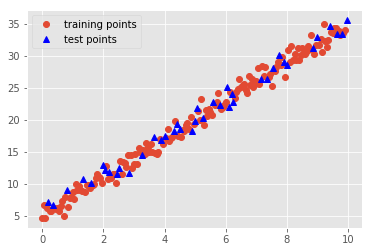

In [9]:
# We initialize the two parameters a0 and b0 as well as the standard deviation s0
a0 = 3
b0 = 5
s0 = 1

# Create the samples:

# x_all is an array from 0 to 10 in steps of 0.05, so 200 in total, which is also given by n_all
x_all = np.arange(0, 10, .05)

# x_all.shape would return "(200,)" and x_all.shape[0] returns the first dimension
n_all = x_all.shape[0]

# gamma_all is the offset. We create an array of random numbers of length 200 with np.random.rand(200)
gamma_all = s0*np.random.randn(n_all)

# The original function without offset is f(x) = 3 * x + 5
# Now we create the noisy function by adding the random offset
# We do this conveniently by zipping the two lists together
y_all = np.asarray([a0*x+b0+o for x, o in zip(x_all, gamma_all)])
    
# Randomize the 200 numbers and get 80% = 160 for training
permx = np.random.permutation(n_all)
n_train = n_all*80//100

# The training set consists of the first 160 numbers of permx (:160), the test set of the rest (160:)
permx_train = permx[:n_train]
permx_test = permx[n_train:]

# Here, we take the shuffled indices and apply them to the original sets
# See down below for a simple example of how this works
x_train = x_all[permx_train]
y_train = y_all[permx_train]

x_test = x_all[permx_test]
y_test = y_all[permx_test]

# Plot the training and test sets
plt.plot(x_train, y_train, "o", x_test, y_test, "b^")
plt.legend(('training points', 'test points'),  loc='upper left')

Shuffling can be easily done using permuted indices:

In [10]:
# Define some array
arr = np.array([110,111,112,113,114,115,116])

# Define a sub-array for a set of indices
idx_1_3 = [1,3]

# Pass the sub-array as a set of indices to the original array
sub_arr = arr[idx_1_3]

print("arr: {}".format(arr))
print("idx_1_3: {}".format(idx_1_3))
print("arr[idx_1_3]: {}".format(sub_arr))

arr: [110 111 112 113 114 115 116]
idx_1_3: [1, 3]
arr[idx_1_3]: [111 113]


In [11]:
# Define a set of indices an randomize them
ordered_idx = np.arange(len(arr))
permuted_idx = np.random.permutation(len(arr))

print("ordered_idx: {}".format(ordered_idx))
print("permuted_idx: {}".format(permuted_idx))

# Apply the randomized indices to the original set
permuted_arr = arr[permuted_idx]

print("arr: {}".format(arr))
print("permuted_arr: {}".format(permuted_arr))

ordered_idx: [0 1 2 3 4 5 6]
permuteded_idx: [6 0 4 2 1 3 5]
arr: [110 111 112 113 114 115 116]
permuted_arr: [116 110 114 112 111 113 115]


We will then define the loss function as the mean of squared residuals for the points.

We will use [stochactic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent): On each iteration we use only a fraction (`mini_batch_size`) of the training set. In many cases, the training set is huge and cannot be fed on each iteration. Also, it can sometimes help the optimizer to properly explore the manifold.

We perform optimization several times for all traininng dataset. Going through the whole dataset once is refered to as 'epoch'. When we do trainings it's usually done in two loops. In the outer loop we iterate over all the epochs. For each epoch we usually split the dataset into small chuncks, 'mini-batches', and optimize its performance for all of those.

Epoch: 000, Loss: 4.3302, a: 3.581, b: 1.319
Epoch: 040, Loss: 1.0367, a: 3.130, b: 4.235
Epoch: 080, Loss: 0.9057, a: 3.034, b: 4.809
Epoch: 120, Loss: 0.9281, a: 2.989, b: 4.921
Epoch: 160, Loss: 0.9095, a: 3.030, b: 4.952
Epoch: 200, Loss: 0.9117, a: 2.995, b: 4.951


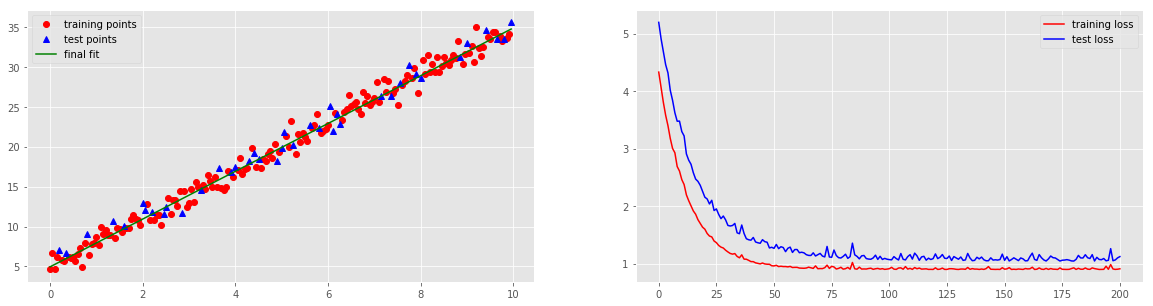

In [12]:
# Reset the graph
tf.reset_default_graph()

# We define two trainable parameters (a and b) and two variables (x and y)
a = tf.get_variable(name='a', dtype=tf.float32, initializer=tf.random_normal(()))
b = tf.get_variable(name='b', dtype=tf.float32, initializer=tf.random_normal(()))
x = tf.placeholder(name='x', dtype=tf.float32, shape=(None))
y = tf.placeholder(name='y', dtype=tf.float32, shape=(None))

# The first residual is y - a * x - b
# The second residual is (y - a * x - b)^2
# The loss function is the mean of the second residual, this is what will be minimized
residual = y - tf.multiply(x,a) - b
residual2 = tf.square(residual)
loss = tf.reduce_mean(residual2)

# Here's the magic, the definition of the optimizer, the learning rate and the mini batch size
optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
mini_batch_size = 10

# Empty arrays for plotting the loss function
l_sv_train = []
l_sv_test = []

# Start the session
with tf.Session() as sess:
    
    # Initialize all the global variables 
    sess.run(tf.global_variables_initializer())
    
    # Iterate training for 200 epochs
    for epoch in range (201):
        
        # Shuffle the data and perform stochastic gradient descent by running over all minibatches
        # n_train is 160 (see above)
        idx = np.random.permutation(n_train)

        # The number of runs per epoch is equal to n_train / mini_batch_size = 200 / 10 = 20
        for run in range(n_train//mini_batch_size):
            
            # Here's the definiton of the sub_index of each run
            # Run 0: idx[0:10]
            # Run 1: idx[10:20]
            # ...
            # Run 19: idx[190:200]
            sub_idx = idx[mini_batch_size*run:mini_batch_size*(run+1)]
            
            # Here's where the session is run and where the corresponding sub indices are fed into the variables x and y
            sess.run(optimizer, feed_dict={x:x_train[sub_idx], y:y_train[sub_idx]})
            
        # Evaluate and save test and training loss to be plotted in the end
        # a and b have been optimized and we check this by running them against the loss function
        l_val_test = sess.run(loss, feed_dict={x:x_test, y:y_test})
        l_val_train = sess.run(loss, feed_dict={x:x_train, y:y_train})
        
        # Add the train and test loss values to the arrays
        l_sv_test.append(l_val_test)
        l_sv_train.append(l_val_train)
        
        # We print running results every 40th epoch of the current loss function value (which should go down) and current values of a and b
        if epoch%40==0:
            l_val, a_val, b_val = sess.run([loss, a, b], feed_dict={x:x_train, y:y_train})
            print("Epoch: {:03d}, Loss: {:.4f}, a: {:.3f}, b: {:.3f}".format(epoch, l_val, a_val, b_val))

# Defining the final fit line
# end_fit_x is the interval from the first element (x_all[0] = 0) to the last element (x_all[-1] = 9.95)
end_fit_x = [x_all[0], x_all[-1]]

# end_fit_y are the function values with the optimized a and b values
end_fit_y = [a_val*x+b_val for x in end_fit_x]

# true_fn_y are the "true" function values without noise (using a0 = 3 and b0 = 5)
# It's commented out as it's not used
#true_fn_y = [a0*x+b0 for x in end_fit_x]

# subplots(rows, columns, figsize) returns figure (which we discard) and axes (which we specify afterwards)
_, axs = plt.subplots(1, 2, figsize=(20,5))

# axs[0] is the first graph
# We plot the training set, the testing set and the final fit line
axs[0].plot(x_train, y_train, 'ro', x_test, y_test, 'b^', end_fit_x, end_fit_y, 'g')
axs[0].legend(('training points', 'test points', 'final fit'),  loc='upper left')

# axs[1] is the second graph
# We take the length of l_sv_train (201) as the x-axis and plot the training and testing loss over it
ep_arr = np.arange(len(l_sv_train))
axs[1].plot(ep_arr, l_sv_train, 'r', ep_arr, l_sv_test, 'b')
axs[1].legend(('training loss', 'test loss'),  loc='upper right')

## Bulding blocks of a neural network

Neural network consist of layers of neurons. Each neuron performs two operations.

1. Calculate the linear transformation $z$ of the input vector $\bar x$:

$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$

where $\bar W$ is the weights vector and $b$ the bias.

2. Perform the nonlinear transformation of the result using activation function $f$:

$$y = f(z)$$

Here, we will use rectified linear unit activation.

In a **fully connected** neural network, each layer is a set of N neurons, performing different transformations on **all** of the previous layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]$:

$$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since the output of each layer forms the input for the next layer, we can write for any layer $k$:

$$x^k_j = f(\bar W^k_j \cdot \bar x^{k-1} + b^k_j)$$

$\bar x^0$ is the network's input vector.

But first, let's look at flatten(), which we'll use in a second.

In [13]:
# Define a 2-dimensional array
arr2d = np.array([[0,1],[2,3]])
print("arr2d:")
print(arr2d)

# Flatten the array to a 1-dimensional array
arr_flat = arr2d.flatten()
print("arr_flat: {}".format(arr_flat))

arr2d:
[[0 1]
 [2 3]]
arr_flat: [0 1 2 3]


To simplify building the network, we'll define a helper function, creating neuron layers with a given number of outputs:

In [14]:
# Define the helper function fully_connected_layer()
def fully_connected_layer(x, n_output, name=None, activation=None):
    
    """Fully connected layer.

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        TF Scope to apply
    activation : None, optional
        Non-linear activation function

    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of the fully connected layer and the weight matrix
    """
    
    # If the length of the shape of the input tensor isn't equal to 2, we flatten the tensor
    # @Q: This does not seem to work. Even though it should, the example below is taken straight from the TensorFlow website
    #     https://www.tensorflow.org/api_docs/python/tf/layers/flatten
    #     Also, flatten() does not seem to have an parameter "reuse"
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=None)

    # @Q: I don't quite understand what happens here and why we take the second (dimension) element
    #     Also see below as I played around with it a bit, but not totally, since I couldn't get flatten() to work
    n_input = x.get_shape().as_list()[1]

    # variable_scope is a context manager for defining ops that create variables (layers).
    # Here, we define the weight tensor W, a constant tensor b, and the output tensor h
    with tf.variable_scope(name or "fc", reuse=None):
        
        # The Xavier Initializer is used to initialize the weight tensor
        # Also see https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        # b is initialized as 0
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        # Here, a bias is added to the value. The bias is b and the value is the matrix multiplication of input x and weight W
        # Also see https://www.tensorflow.org/api_docs/python/tf/nn/bias_add
        # and      https://www.tensorflow.org/api_docs/python/tf/linalg/matmul
        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        # If an activation function is passed, it is applied to h before it is returned
        if activation:
            h = activation(h)

        return h, W

In [15]:
x = tf.placeholder(shape=(2, 3, 4), dtype='float32')
#y = flatten(x)

In [16]:
# Some playing around with tensors, shapes, conversions to lists and such
x = tf.placeholder(shape=(2, 3, 4), dtype='float32')
print("get_shape(): {}".format(x.get_shape()))
print("len(get_shape()): {}".format(len(x.get_shape())))
print("get_shape().as_list(): {}".format(x.get_shape().as_list()))
print("get_shape().as_list()[1]: {}".format(x.get_shape().as_list()[1]))
x.get_shape()

get_shape(): (2, 3, 4)
len(get_shape()): 3
get_shape().as_list(): [2, 3, 4]
get_shape().as_list()[1]: 3


TensorShape([Dimension(2), Dimension(3), Dimension(4)])

## Building a neural network

In the case of classification, in the the last layer we use *softmax* transformation as non-linear transformation:

$$y_i = \sigma(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

This will correspond to the one-hot labels that we use. **One-hot** is a group of bits among which the legal combinations of values are only those with a single high bit (1) and all the others low (0). A similar implementation in which all bits are '1' except one '0' is sometimes called one-cold.

Finally we will use the cross entropy as the loss function:

$$H(Y_{pred}, Y_{true}) = - \sum_i Y_{true}^i \log(Y_{pred}^i)$$

In [17]:
# Define input and output of the neural network
n_input = 10
n_output = 2

# Initialize graph
# @Q: We do we not reset the graph?
g = tf.Graph()

# as_default() returns a context manager that makes this graph the default graph.
# See also https://www.tensorflow.org/api_docs/python/tf/Graph#as_default
with g.as_default():
    
    # Define placeholders for input and output tensors
    # @Q: We do we need to define Y? It's not used and can be commented out without impact
    X = tf.placeholder(name='X', dtype=tf.float32, shape=[None, n_input])
    #Y = tf.placeholder(name='Y', dtype=tf.float32, shape=[None, n_output])
    
    # Layer 1 - fully connected: 10 inputs => 4 neurons. Sigmoid activation
    # Computes sigmoid of x element-wise. Specifically, y = 1 / (1 + exp(-x)).
    # Also see https://www.tensorflow.org/api_docs/python/tf/math/sigmoid
    L1, W1 = fully_connected_layer(X , 4, 'L1', activation=tf.sigmoid)
    
    # Layer 2 - fully connected: Take the input from layer 1 (4 neurons) and apply it to the 2 neurons from layer 2. No activation
    L2, W2 = fully_connected_layer(L1 , 2, 'L2', activation=None)
    
    # Output Layer: Take the input from layer 2 and use Softmax activation
    # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)
    # Also see https://www.tensorflow.org/api_docs/python/tf/nn/softmax
    Y_onehot = tf.nn.softmax(L2, name='Softmax')
    
    # Prediction: onehot => integer
    Y_pred = tf.argmax(Y_onehot, axis=1, name='Y_pred')

In [18]:
# @Q: Where does "Y" come from? I've commented it out, yet it keeps appearing
gr_disp.show(g.as_graph_def())

## Handwritten digit recognition

First, we need to download a file from the internet. We'll do this with urllib.request. Then we have to unpack the .tgz with PowerShell using the "tar -xvzf t3.tgz" command.

In [19]:
# We only need to do this once, so the code is commented out.

#import urllib.request
#url = 'http://scits-training.unibe.ch/data/tut_files/t3.tgz'
#urllib.request.urlretrieve(url, 'C:/Users/marco/t3.tgz')

In [20]:
# To read the data set, we need the following (which is depreciated):
import tensorflow.examples.tutorials.mnist.input_data as input_data

ds = input_data.read_data_sets('MNIST_data/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [21]:
# X are the images, Y the labels
# These are likely pre-defined sets because we imported learning data
Xs = ds.train.images
Ys = ds.train.labels
Xs_test = ds.test.images
Ys_test = ds.test.labels
Xs_valid = ds.validation.images
Ys_valid = ds.validation.labels

# The shape tells us how many images there are and what resolution (number of pixels) they come with, e.g. 55,000 images with 784 pixels each for Xs
# The labels are encoded in one-hot format (see down below)
print ('Train - Data shape:', Xs.shape, '/ Label shape:', Ys.shape)
print ('Validation - Data shape:', Xs_valid.shape, '/ Label shape:', Ys_valid.shape)
print ('Test - Data shape:', Xs_test.shape, '/ Label shape:', Ys_test.shape)

Train - Data shape: (55000, 784) / Label shape: (55000, 10)
Validation - Data shape: (5000, 784) / Label shape: (5000, 10)
Test - Data shape: (10000, 784) / Label shape: (10000, 10)


In [22]:
# A short function to transfer the array into a 28x28 format
def get_image(flatimg):
    return flatimg.reshape(28, 28)

One-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] . Actual label: 9


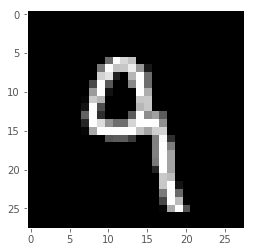

In [23]:
# We can get any image we linke by changing the image number
imgnr = 24

# Get the image and reshape it. Otherwise, we would just the a single line with 784 pixels
img = get_image(Xs[imgnr])

# Turn the array of 784 pixels into a picture
plt.imshow(img, cmap='gray', interpolation='nearest')

# Don't print the grid
plt.grid(False)

# We get the one-hot encoding as well as the index of where the '1' is with np.argmax()
print('One-hot label:',Ys[imgnr], '. Actual label:', np.argmax(Ys[imgnr]))

## Building a neural network

Number of input neurons will be given by input data, i.e. image size = 28 * 28 = 784. Output by number of classes, the ten digits in our case.

In [24]:
n_input = Xs.shape[1]   # 784
n_output = Ys.shape[1]  # 10

Lets first build a simple network with just one layer.

In [25]:
# Initialize the graph
g = tf.Graph()

with g.as_default():
    
    # Define input and output tensors X and Y
    X = tf.placeholder(name='X', dtype=tf.float32, shape=[None, n_input])
    Y = tf.placeholder(name='Y', dtype=tf.float32, shape=[None, n_output])
    
    # layer 1: 784 inputs => 10 neurons. Softmax activation
    L1, W1 = fully_connected_layer(X , n_output, 'L1')
    
    # In statistics, the logit function is the logarithm of the odds p/(1 − p).
    # It is a type of function that creates a map of probability values from [0,1] to [-\infty, +\infty].
    # It is the inverse of the sigmoidal "logistic" function or logistic transform
    # See also https://en.wikipedia.org/wiki/Logit
    Y_onehot = tf.nn.softmax(L1, name='Logits')
    
    # Prediction: onehot => integer
    Y_pred = tf.argmax(Y_onehot, axis=1, name='YPred')
    
    # Minimize softmax cross entropy between logits and labels with the Adam optimizer
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=L1, labels=Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.003).minimize(cross_entropy)
    
    # Get fraction of correctly assigned labels
    
    # 'Y_true' is the correct label
    # Note that above we use np.argmax() and here we use tf.argmax()
    Y_true = tf.argmax(Y, 1)
    
    # 'Correct' measures element-wise whether the true labels and the predicted labels match
    Correct = tf.equal(Y_true, Y_pred, name='CorrectY')
    
    # We cast the Boolean tensor 'Correct' as a float and calculate the mean over the whole row, giving us the accuracy
    Accuracy = tf.reduce_mean(tf.cast(Correct, dtype=tf.float32), name='Accuracy')

We will train for 5 epochs, with minibatches of size 64. This is very similar to what we did in last session. Split the data into minibatches and run the optimizer. Store the training and validadtion accuracy for each epoch and then plot them.

Test accuracy: 91.75%, Validation accuracy: 92.40%
Test accuracy: 92.39%, Validation accuracy: 92.64%
Test accuracy: 92.64%, Validation accuracy: 92.66%
Test accuracy: 92.92%, Validation accuracy: 92.94%
Test accuracy: 93.06%, Validation accuracy: 92.66%


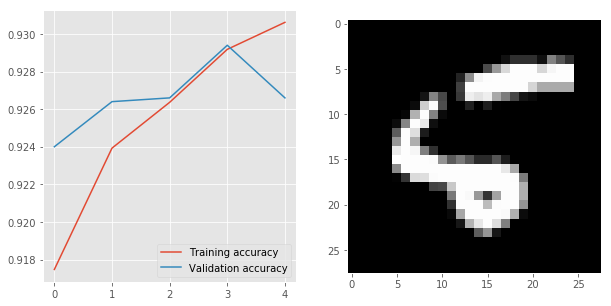

Predicted label: 6 , True label: 5


In [26]:
# Start a training session with the neural network g we defined above
with tf.Session(graph=g) as sess:
    
    # Arrays for the accuracies of the training and validation sets
    acc_trn = []
    acc_val = []

    # ALways initialize the global variables
    sess.run(tf.global_variables_initializer())

    # Now we actually do some training
    # Define the size of the mini batches and the number of epochs
    mini_batch_size = 64
    n_epochs = 5
    
    for epoch_i in range(n_epochs):
        
        # Xs.shape[0] is the number of training images = 55,000
        for mb_idx in range(Xs.shape[0] // mini_batch_size):
            
            # @Q: I don't quite understand how train.next_batch() works in detail as I couldn't find documentation on it
            #     and it seems to be a function specific to this training data set
            x_batch, y_batch = ds.train.next_batch(mini_batch_size)
            
            # Here, we feed the images and labels of the mini batch into the (Adam) optimizer as defined above
            sess.run(optimizer, feed_dict={X: x_batch, Y: y_batch})
        
        # Here, we get the accuracy on the training and validation sets, add them to the arrays and print them
        acr_t = sess.run(Accuracy, feed_dict={X: Xs, Y: Ys})
        acr_v = sess.run(Accuracy, feed_dict={X: Xs_valid, Y: Ys_valid})

        acc_trn.append(acr_t)        
        acc_val.append(acr_v)

        print("Test accuracy: {:.2%}, Validation accuracy: {:.2%}".format(acr_t, acr_v))
        
    # Get the final test accuracy
    
    # 'corr' is a Boolean array and 'accr' the accuracy
    # 'Correct' and 'Accuracy' are defined above
    # Note that we feed the test images and labels
    corr, accr = sess.run((Correct, Accuracy), feed_dict={X: Xs_test, Y: Ys_test})
    
    # Get the index of the first incorrectly recognized digit and display it
    
    # 'enumerate' is a Python function that makes a dictionary of indices and values
    # See https://wiki.python.org/moin/UsingEnumerate
    # So here we get an array with the indices of all the false predictions
    wrong_idx  = [i for i,c in enumerate(corr) if c == False]
    
    # Get the index of the first false prediction
    wrong_idx0 = wrong_idx[0]
    
    # To get the corresponding label, we have to do some more work
    # We take Y_pred which converts the one-hot softmax prediction of layer 1 into an integer
    # and feed it a very short array
    # @Q: Why do we do this? Isn't there an easier way to get the label?
    #     We basically feed (in this case) sess.run(Y_pred, feed_dict={X: Xs_test[8:9], Ys_test[8:9]})
    wrong_lbl = sess.run(Y_pred, feed_dict={X: Xs_test[wrong_idx0:wrong_idx0+1], Y: Ys_test[wrong_idx0:wrong_idx0+1]})
    wrong0_lbl = wrong_lbl[0]
    
    # Store final value of the weight matrix W1
    W1_result = sess.run(W1)
    
    # subplot produces figure (which we discard) and axes (which we set afterwards)
    _, axs = plt.subplots(1, 2, figsize=(10,5))
    
    # axs[0] is the left graph. We plot training and validation accuracies
    axs[0].plot(acc_trn)
    axs[0].plot(acc_val)
    axs[0].legend(('Training accuracy', 'Validation accuracy'), loc='lower right')
    
    # axs[1] is the right graph. Here we show a falsely predicted number
    axs[1].imshow(get_image(Xs_test[wrong_idx0]), cmap='gray', interpolation='nearest')
    axs[1].grid(False)
    plt.show()
    
    print('Predicted label:',wrong0_lbl, ', True label:', np.argmax(Ys_test[wrong_idx0]))

Let's visualize the trained weights:

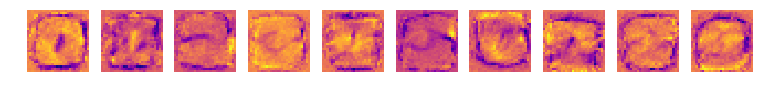

In [27]:
# W1 has shape input x output, so 784 * 10, which we reshape to 28 * 28 * 10, or ten pictures with shape 28 x 28
W1_result = W1_result.reshape(28,28,10)

# Make the graph consisting of ten sub graphs
_, axs = plt.subplots(1, 10, figsize=(13,5))

# @Q: I don't understand the notation W1_result[..., i]
for i in range(10):
    axs[i].imshow(W1_result[..., i], cmap='plasma', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')

## Gradients visualization

Build a network with two layers. The first layer with Rectified Linear Unit (ReLU) activation and 1,500 neurons and the second one with 10 neurons and softmax activation. Start with a lerning rate of 0.001 and find the optimal value.

In [28]:
#Initialize graph
g = tf.Graph()

with g.as_default():
    
    # Define the placeholders
    X = tf.placeholder(name='X', dtype=tf.float32, shape=[None, n_input])
    Y = tf.placeholder(name='Y', dtype=tf.float32, shape=[None, n_output])
    
    # layer 1: 784 inputs => 1500 neurons. ReLU activation
    L1, W1 = fully_connected_layer(X, 1500, "L1", tf.nn.relu)
    
    # Layer 2: 1,500 inputs => 10 neurons. No activation
    L2, W2 = fully_connected_layer(L1, 10, "L2")
    
    # Get a prediction with softmax
    Y_onehot = tf.nn.softmax(L2, name='Logits')
    Y_pred = tf.argmax(Y_onehot, axis=1, name='YPred')
    
    # Minimize softmax cross entropy between logits and labels with the Adam optimizer
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=L2, labels=Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)
    
    # Get fraction of correctly assigned labels
    
    # 'Y_true' is the correct label
    Y_true = tf.argmax(Y, 1)
    
    # 'Correct' measures element-wise whether the true labels and the predicted labels match
    Correct = tf.equal(Y_true, Y_pred, name="CorrectY")
    
    # We cast the Boolean tensor 'Correct' as a float and calculate the mean over the whole row, giving us the accuracy
    Accuracy = tf.reduce_mean(tf.cast(Correct, dtype=tf.float32), name="Accuracy")
    
    # For visualization we will calculate the gradients of each of 10 outputs over input X
    # Also see https://www.tensorflow.org/api_docs/python/tf/gradients
    # @Q: I don't understand the notation "Y_onehot[..., i]"
    yh_grad = [tf.gradients(Y_onehot[..., i], X) for i in range(10)]
    
    # Gradient with maximal output over input X
    ym_grad = tf.gradients(tf.reduce_max(Y_onehot, axis=1), X)

Test accuracy: 96.88%, Validation accuracy: 96.36%
Test accuracy: 98.35%, Validation accuracy: 97.18%
Test accuracy: 99.04%, Validation accuracy: 97.98%
Test accuracy: 99.28%, Validation accuracy: 97.98%
Test accuracy: 99.35%, Validation accuracy: 97.84%
Final test accuracy: 97.88%


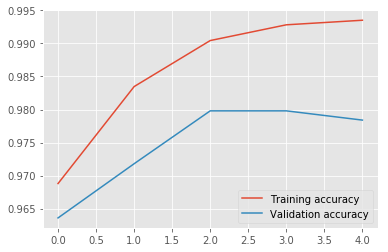

In [29]:
with tf.Session(graph=g) as sess:
    
    #Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    acc_val = []
    acc_trn = []

    mini_batch_size = 64
    n_epochs = 5
    
    for epoch_i in range(n_epochs):
        
        for mb_idx in range(ds.train.num_examples // mini_batch_size):
            
            x_batch, y_batch = ds.train.next_batch(mini_batch_size)
            
            sess.run(optimizer, feed_dict={X: x_batch, Y: y_batch})

        acr_t = sess.run(Accuracy, feed_dict={X: Xs, Y: Ys})
        acr_v = sess.run(Accuracy, feed_dict={X: Xs_valid, Y: Ys_valid})

        acc_trn.append(acr_t)
        acc_val.append(acr_v)
        
        print("Test accuracy: {:.2%}, Validation accuracy: {:.2%}".format(acr_t, acr_v))
        
    # Save the gradients for later
    yh_grad_res, ym_grad_res = sess.run((yh_grad, ym_grad), feed_dict={X: Xs_test})
    
    # Print final test accuracy:
    print('Final test accuracy: {:.2%}'.format(sess.run(Accuracy, feed_dict={X: Xs_test, Y: Ys_test})))
    
    plt.plot(acc_trn)
    plt.plot(acc_val)
    plt.legend(('Training accuracy', 'Validation accuracy'), loc='lower right')

We will display several images and corresponding gradients of maximal output activation as well as all activations. This might help us better understand how our network processes the input data.

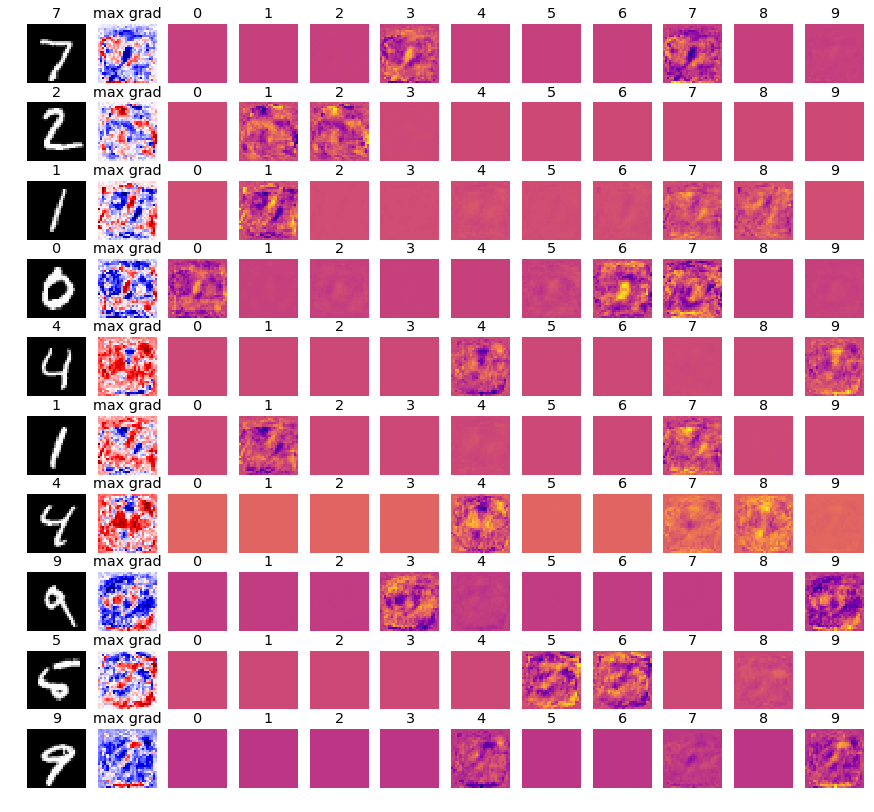

In [30]:
# Reshape the gradients into arrays and then into 28x28 pictures
# @Q: I don't quite understand the syntax of reshape() as it doesn't match the documentation
grad = np.asarray(yh_grad_res)
grad = grad.reshape(grad.shape[0], grad.shape[2], 28,28)
gradm = np.asarray(ym_grad_res[0])
gradm = gradm.reshape(gradm.shape[0], 28,28)

n_img_d = 10
_, axs = plt.subplots(n_img_d, 12, figsize=(15,17./12*n_img_d))
for i in range(n_img_d):
    axs[i, 0].imshow(get_image(Xs_test[i]), cmap='gray', interpolation='nearest')
    axs[i, 0].set_title(np.argmax(Ys_test[i]))
    axs[i, 0].grid(False)
    axs[i, 0].axis('off')

    axs[i, 1].imshow(gradm[i], cmap='seismic', interpolation='nearest')
    axs[i, 1].set_title('max grad')
    axs[i, 1].grid(False)
    axs[i, 1].axis('off')

    gmin = np.min(grad[:, i, ...])
    gmax = np.max(grad[:, i, ...])
    for j in range(10):
        axs[i,j+2].set_title(str(j))
        axs[i,j+2].imshow(grad[j, i], cmap='plasma', interpolation='nearest', vmin = gmin, vmax = gmax)
        axs[i,j+2].grid(False)
        axs[i,j+2].axis('off')

## Convolutions

In fully connected network all inputs are connected to all neurons of next layer:
<tr>
    <td> <img src="attachment:image.png" alt="drawing" width="100px"/></td> 
    <td> <img src="attachment:image1.png" alt="drawing" width="300px"/></td> 
</tr>

<br>In convolutional nets the same holds for each neighbourhood, and the weights are shared:<br>
![CNN1.png](attachment:CNN1.png)<br>
![CNN2.png](attachment:CNN2.png)<br>
![CNN3.png](attachment:CNN3.png)

In [31]:
# @Q: Why do the embedded pictures above not work and how can you fix it?

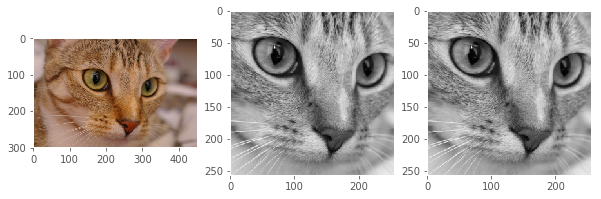

In [32]:
# Load original image
cat = plt.imread('C:/Users/marco/ML3/chelsea.jpg')

# Make the graph consisting of three sub graphs
_, axs = plt.subplots(1, 3, figsize=(10,5))
    
# Dispay original image
axs[0].imshow(cat)
axs[0].grid(False)

# imread()[y1:y2 , x1:x2] defines how the image is cropped - or in this case, cat[y1:y2 , x1:x2]
cat_cropped = cat.mean(axis=2)[-256:, 100:356]

# @Q: I don't understand what astype() is for as I've commented it out and it seems to work
#.astype(np.float32)
# @Q: I don't quite understand why mean(axis=2) makes the picture weirdly blue-green
# Original code: cat_cropped = plt.imread('C:/Users/marco/ML3/chelsea.jpg').mean(axis=2)[-256:, 100:356].astype(np.float32)

# cmap = 'gray' only matters in connection with cat.mean(axis=2)
axs[1].imshow(cat_cropped, cmap='gray') 
axs[1].grid(False)

# @Q: This normalizes the data somehow, but I don't understand quite what it does
#     Except that we need it later on
cat_normalized = (cat_cropped-cat_cropped.mean())/cat_cropped.std()

axs[2].imshow(cat_normalized, cmap='gray') 
axs[2].grid(False)

In [33]:
# Initialize the graph
g = tf.Graph()

with g.as_default():
   
    # Convolve 5 times with a 5x5 filter

    x   = tf.placeholder(dtype=tf.float32, shape=(1,256,256,1), name='img')
    flt = tf.placeholder(dtype=tf.float32, shape=(5,5,1,1)    , name='flt')
    
    # nn.conv2d computes a 2-D convolution given 4-D input and filter tensors.
    # Given an input tensor of shape [batch, in_height, in_width, in_channels]
    # and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
    # This op performs the following:
    # Flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels]
    # Extracts image patches from the input tensor to form a virtual tensor of shape [batch, out_height, out_width, filter_height * filter_width * in_channels]
    # For each patch, right-multiplies the filter matrix and the image patch vector.
    # Also see https://www.tensorflow.org/api_docs/python/tf/nn/conv2d
    y1 = tf.nn.conv2d(x , flt, strides=[1,1,1,1], padding='VALID', name='convolved')
    y2 = tf.nn.conv2d(y1, flt, strides=[1,1,1,1], padding='VALID', name='convolved')
    y3 = tf.nn.conv2d(y2, flt, strides=[1,1,1,1], padding='VALID', name='convolved')
    y4 = tf.nn.conv2d(y3, flt, strides=[1,1,1,1], padding='VALID', name='convolved')

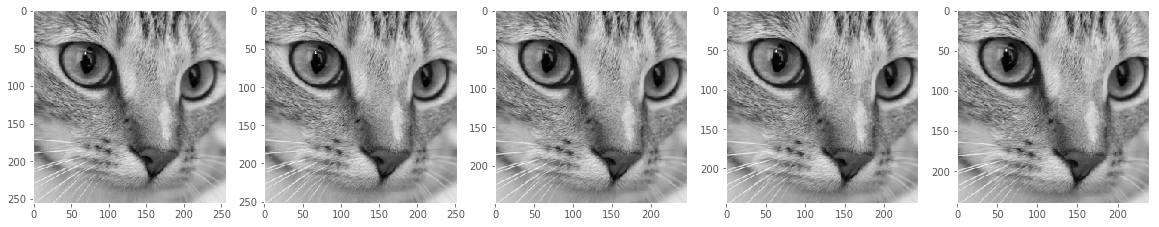

In [34]:
# @Q: I don't understand what this does
#     It seems like it takes the 2d picture and adds a new axis before and after the existing x and y axes
cat4d = cat_normalized[np.newaxis,...,np.newaxis]

# Define filter matrix
flt_mtx = [[ 0, 0, 0, 0, 0,],
           [ 0, 0, 0, 0, 0,],
           [ 0, 0, 1, 0, 0,],
           [ 0, 0, 0, 0, 0,],
           [ 0, 0, 0, 0, 0,],]

# Run session
with tf.Session(graph=g) as sess:
    
    flt_mtx_np = np.array(flt_mtx, np.float32)
    flt_mtx_np = flt_mtx_np[..., np.newaxis, np.newaxis]
    res = sess.run([x,y1,y2,y3,y4], feed_dict={x:cat4d, flt:flt_mtx_np})
    
res = [r[0,...,0] for r in res]
n = len(res)
fig, ax = plt.subplots(1, n, figsize=(n*4, 4))
for col in range(n):
    ax[col].imshow(res[col], cmap='gray')
    ax[col].grid(False)